In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

/Users/varchitalalwani/anaconda3/envs/KERAS_LEARNING/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [27]:
class sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape = (batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [28]:
latent_dim = 2
encoder_input = tf.keras.Input(shape = (28, 28, 1))
x = tf.keras.layers.Conv2D(32, 3, activation = 'relu', strides = 2, padding = 'same')(encoder_input)
x = tf.keras.layers.Conv2D(64, 3, activation = 'relu', strides = 2, padding = 'same')(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(16, activation = 'relu')(x)
z_mean = tf.keras.layers.Dense(latent_dim, name = 'z_mean')(x)
z_log_var = tf.keras.layers.Dense(latent_dim, name = 'z_log_var')(x)
z = sampling()([z_mean, z_log_var])
encoder = tf.keras.Model(encoder_input, [z_mean, z_log_var, z], name = 'encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_2 (Conv2D)              (None, 14, 14, 32)   320         ['input_3[0][0]']                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d_2[0][0]']               
                                                                                                  
 flatten_1 (Flatten)            (None, 3136)         0           ['conv2d_3[0][0]']               
                                                                                            

In [29]:
latent_inputs = tf.keras.Input(shape = (latent_dim,))
x = tf.keras.layers.Dense(7*7*64, activation = 'relu')(latent_inputs)
x = tf.keras.layers.Reshape((7,7,64))(x)
x = tf.keras.layers.Conv2DTranspose(64, 3, activation = 'relu', strides = 2, padding = 'same')(x)
x = tf.keras.layers.Conv2DTranspose(32, 3, activation = 'relu', strides = 2, padding = 'same')(x)
decoder_outputs = tf.keras.layers.Conv2DTranspose(1, 3, activation = 'sigmoid', padding = 'same')(x)
decoder = tf.keras.Model(latent_inputs, decoder_outputs, name = 'decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_3 (Dense)             (None, 3136)              9408      
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 14, 14, 64)       36928     
 ranspose)                                                       
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 28, 28, 1)        289 

In [30]:
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name = 'total_loss')
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name = 'reconstruction_loss')
        self.kl_loss_tracker = tf.keras.metrics.Mean(name = 'kl_loss')
        
    @property
    def metrics(self):
        return[
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker
        ]
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                tf.keras.losses.binary_crossentropy(data, reconstruction), axis = (1,2)))
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis = 1))
            total_loss =  reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return{
            "loss": self.total_loss_tracker.result(),
            'reconstruction_loss': self.reconstruction_loss_tracker.result(),
            'kl_loss': self.kl_loss_tracker.result()
        }

In [31]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis = 0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype('float32') / 255

In [32]:
vae = VAE(encoder, decoder)
vae.compile(optimizer = tf.keras.optimizers.Adam())
vae.fit(mnist_digits, epochs = 30, batch_size = 128)

Epoch 1/30
547/547 [==============================] - 7s 11ms/step - loss: 258.7116 - reconstruction_loss: 201.9774 - kl_loss: 2.6465
Epoch 2/30
547/547 [==============================] - 6s 11ms/step - loss: 166.6615 - reconstruction_loss: 159.6911 - kl_loss: 4.8907
Epoch 3/30
547/547 [==============================] - 6s 11ms/step - loss: 160.1739 - reconstruction_loss: 154.3579 - kl_loss: 5.2750
Epoch 4/30
547/547 [==============================] - 6s 11ms/step - loss: 157.8865 - reconstruction_loss: 151.9090 - kl_loss: 5.4566
Epoch 5/30
547/547 [==============================] - 6s 11ms/step - loss: 156.3262 - reconstruction_loss: 150.2799 - kl_loss: 5.5618
Epoch 6/30
547/547 [==============================] - 6s 11ms/step - loss: 155.3460 - reconstruction_loss: 149.1826 - kl_loss: 5.6362
Epoch 7/30
547/547 [==============================] - 6s 11ms/step - loss: 153.9140 - reconstruction_loss: 148.2199 - kl_loss: 5.6998
Epoch 8/30
547/547 [==============================] - 6s 11ms/

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 6ms/step


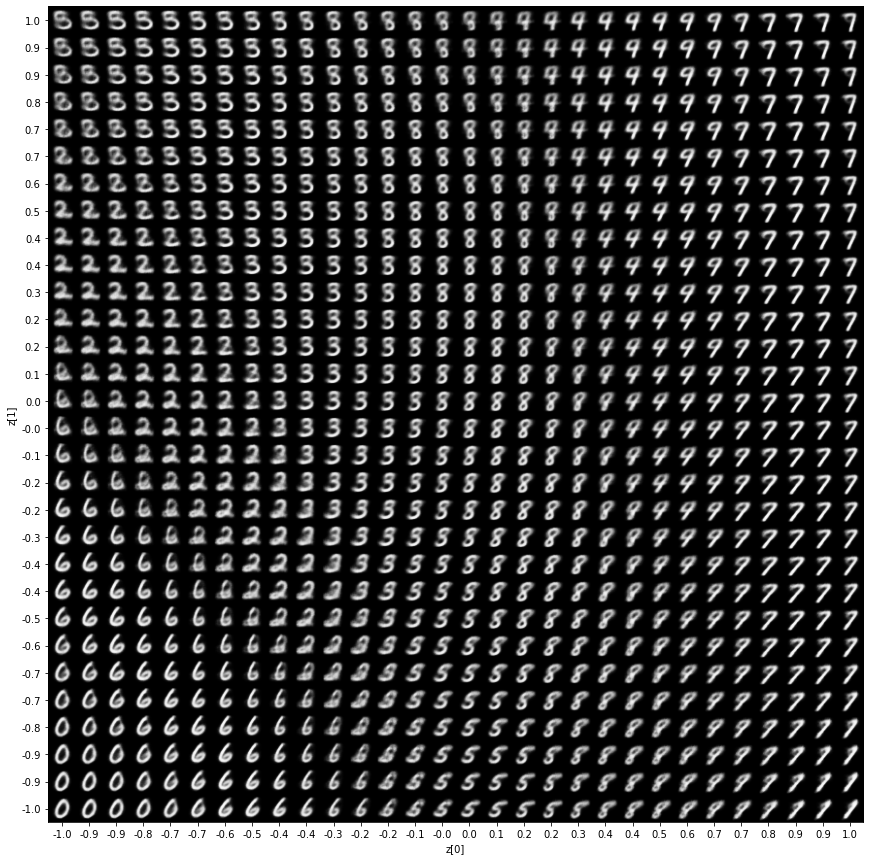

In [33]:
def plot_latent_space(vae, n = 30, figsize = 15):
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]
    
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit
    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()
plot_latent_space(vae)

1875/1875 [==============================] - 2s 1ms/step


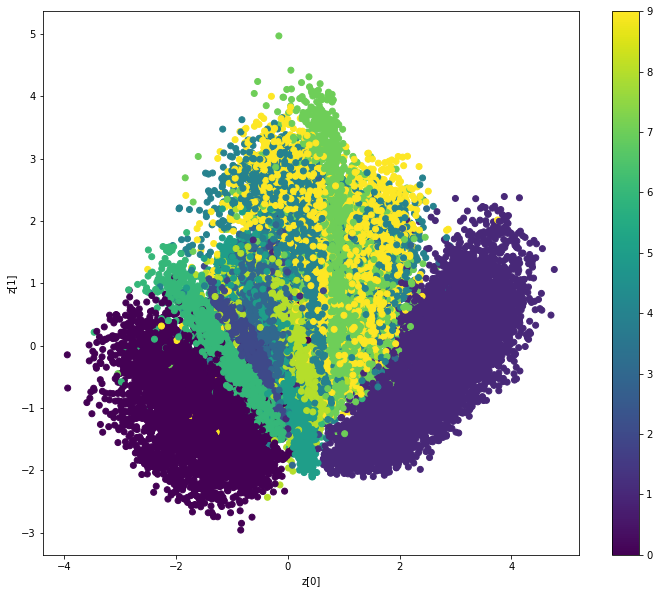

In [36]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, x_train, y_train)